# Data import and preparation

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read training data from CSV
train_data_raw = pd.read_csv('resources/normal.csv')
train_data_raw.shape

(6613, 26)

In [3]:
# Read validation data from CSV
validate_data_raw = pd.read_csv('resources/verify.csv')
validate_data_raw.shape

(5200, 26)

In [4]:
# Choose only columns containing features we want to use for training
feature_list = [" LinAccX (g)"]
features = len(feature_list)
train_data_selected = train_data_raw[feature_list].as_matrix()
validate_data_selected = validate_data_raw[feature_list].as_matrix()

In [5]:
# Convert a dataset into a windowed format - append *window - 1* records to the back of each record. 
# For example:
# window = 2
# dataset =
# [
#  [1, 2, 3],
#  [2, 3, 4],
#  [5, 6, 7]
# ]
#
# Will result in:
# [
#  [0, 0, 0, 1, 2, 3], # padding with 0 since there were no observations before the first one
#  [1, 2, 3, 2, 3, 4],
#  [2, 3, 4, 5, 6, 7]
# ]
def prepare_dataset(dataset, window):
    windowed_data = []
    for i in range(len(dataset)):
        start = i + 1 - window if i + 1 - window >= 0 else 0
        observation = dataset[start : i + 1,]
        to_pad = (window - i - 1 if i + 1 - window < 0 else 0) * features
        observation = observation.flatten()
        observation = np.lib.pad(observation, (to_pad, 0), 'constant', constant_values=(0, 0))
        windowed_data.append(observation)
    return np.array(windowed_data)
    
# Window size - the bigger this value is, the longer our network will "retain" past information i.e. it will take longer
# for newer state to become significant but it will also mean we will use the time dependency factor more into account.
window = 25

# Convert our data into windowed formats
data_train = prepare_dataset(train_data_selected, window)
data_validate = prepare_dataset(validate_data_selected, window)

# Data visualization

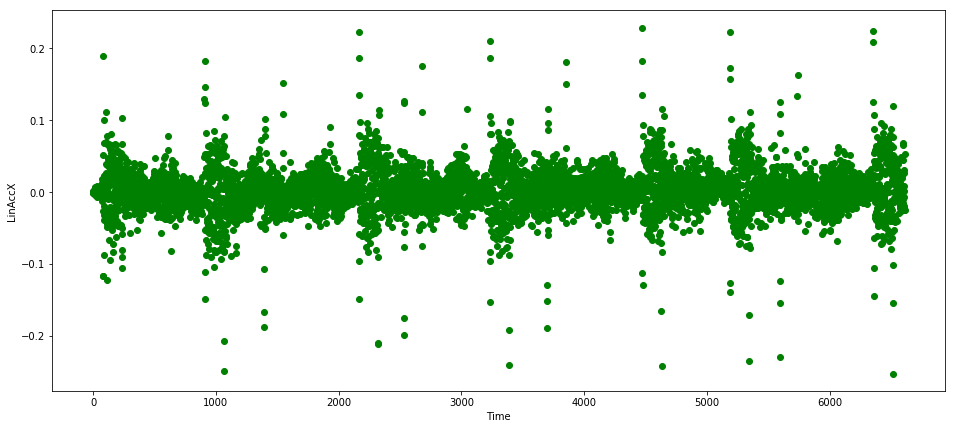

In [6]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(16, 7)

plt.plot(list(range(len(train_data_raw[" LinAccX (g)"]))), train_data_raw[" LinAccX (g)"], "go")
plt.ylabel('LinAccX')
plt.xlabel('Time')
plt.show()

# Multi layer perceptron

In [7]:
from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

In [8]:
# Create an iterator, which will feed our data in a batched fashion into MXNet
train_iter = mx.io.NDArrayIter(
    data={'data': data_train}, 
    label={'data': data_train},
    batch_size=64, shuffle=False, 
    last_batch_handle='pad')

In [9]:
# For this network we will use our windowed data representation, so each record will actually contain all the features
# from *window* number of records hence or total input size:
total_features = window * features

# Placeholder for the input data which will be used for training
data = mx.symbol.Variable('data')
# Connection between input and first hidden layer
fc1 = mx.symbol.FullyConnected(data, name='fc1', num_hidden=16)
# Activation funtion after our hidden layer
act1 = mx.symbol.Activation(fc1, name='act1', act_type='tanh')

fc2 = mx.symbol.FullyConnected(act1, name='fc2', num_hidden=8)
# # Activation funtion after our hidden layer
act2 = mx.symbol.Activation(fc2, name='act2', act_type='relu')

fc3 = mx.symbol.FullyConnected(act2, name='fc3', num_hidden=16)
# # Activation funtion after our hidden layer
act3 = mx.symbol.Activation(fc3, name='act3', act_type='tanh')

# Connection between hidden layer and our output layer - since it is an autoencoder we want the size to be same as input size
out = mx.symbol.FullyConnected(act3, name='fc4', num_hidden=total_features)
# Linear regression output allows us to easily calculate RMSE between output and input layers and use it as loss
loss = mx.symbol.LinearRegressionOutput(data=out, label=data)

model = mx.mod.Module(
    loss,
    context = mx.cpu(0), # use mx.gpu(0) on GPU enabled machines
    data_names=['data'],
    label_names=['data']
)

In [10]:
model.fit(train_iter, 
          num_epoch = 100, 
          eval_metric='rmse',
          optimizer='adam',
          optimizer_params={'learning_rate':0.01, 'wd':0.0001}
)

In [11]:
# Helper method calculating RMSE between two array-like objects
def rmse(targets, predictions):
     return np.sqrt(np.mean((predictions-targets)**2))

# Make predictions for our training data so we can calculate the anomaly threshold
predictions = model.predict(train_iter).asnumpy()
# Even though, we are using LinearRegressionOutput for training, MXNet returns us as output the previous layer,
# meaning the one with *total_features* neurons. We have to compute the RMSE for each record ourselves.
errors = list(map(lambda e: rmse(e[0], e[1]), zip(data_train, predictions)))
# We will treat as anomalies records, for which error is far from the mean. We'll consider only the furthest 0.1%
# this means records which are 3 standard deviations from the mean
threshold =  np.mean(errors) + 3*np.std(errors)

In [12]:
# Prepare the validation dataset for predictions
test_iter = mx.io.NDArrayIter(
    data={'data': data_validate}, 
    label={'data': data_validate},
    batch_size=64, shuffle=False, 
    last_batch_handle='pad')

predictions = model.predict(test_iter).asnumpy()
errors = list(map(lambda e: rmse(e[0], e[1]), zip(data_validate, predictions)))
# Every record, for which the prediction RMSE is bigger than the threshold is considered an anomaly
anomaly = list(map(lambda v: v > threshold, errors))

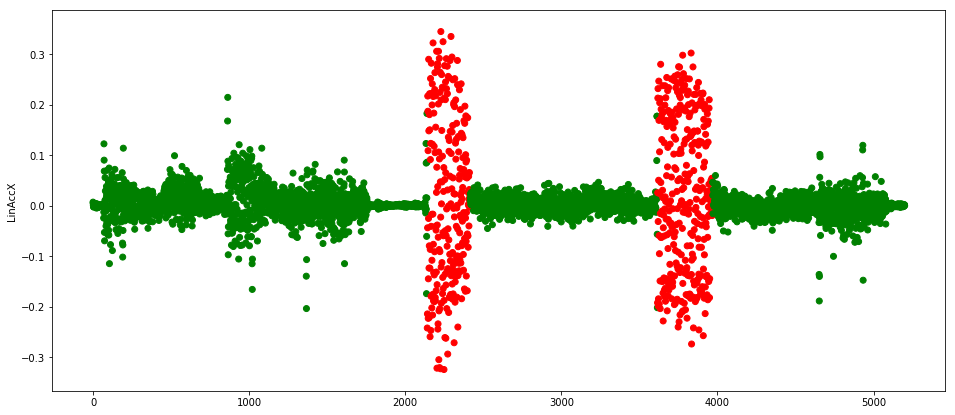

In [13]:
# Result visualization
anomaly = list(map(lambda v: "red" if v else "green", anomaly))
plt.scatter(list(range(len(validate_data_raw[" LinAccX (g)"]))), validate_data_raw[" LinAccX (g)"], c=anomaly)
plt.ylabel('LinAccX')
plt.show()

# Long-short term memory

In [24]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np

In [25]:
data_ctx = mx.cpu()
model_ctx = mx.cpu() # mx.gpu() for GPU

In [26]:
# Setup iterators for Gluon to feed our model with batched data during training
batch_size = 64
train_data = mx.gluon.data.DataLoader(train_data_selected.astype(np.float32), batch_size, shuffle=False)
validate_data = mx.gluon.data.DataLoader(validate_data_selected.astype(np.float32), batch_size, shuffle=False)

In [27]:
model = mx.gluon.nn.Sequential()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTM(window, num_layers=1))
    model.add(gluon.nn.Dropout(.5))
    model.add(mx.gluon.rnn.LSTM(64, num_layers=1))
    model.add(gluon.nn.Dropout(.5))
    model.add(mx.gluon.rnn.LSTM(window, num_layers=1))
    model.add(gluon.nn.Dropout(.5))
    model.add(mx.gluon.rnn.LSTM(features, num_layers=1))

# Use the non default Xavier parameter initializer
model.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)

# Use Adam optimizer for training
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.01})

# Similarly to previous example we will use L2 loss for evaluation
L = gluon.loss.L2Loss()

In [28]:
epochs = 10
moving_loss = 0.

# Gluon training loop
for e in range(epochs):
    for i, data in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,features,1))
        label = data
        with autograd.record():
            output = model(data)
            loss = L(output, label)
        loss.backward()
        trainer.step(batch_size)
    print("Epoch %s." % (e))

Epoch 0.
Epoch 1.
Epoch 2.
Epoch 3.
Epoch 4.


In [29]:
# Helper method running predictions in a batched fashion
def predict(to_predict, L):
    predictions = []
    for i, data in enumerate(to_predict):
        input = data.as_in_context(model_ctx).reshape((-1,features,1))
        out = model(input).flatten()
        prediction = L(out, data).asnumpy()
        predictions = np.append(predictions, prediction)
    return predictions

In [30]:
train_predictions = predict(train_data, L)
threshold =  np.mean(train_predictions) + 3*np.std(train_predictions)

In [31]:
validation_predictions = predict(validate_data, L)

In [32]:
anomaly = list(map(lambda v: v > threshold, validation_predictions))

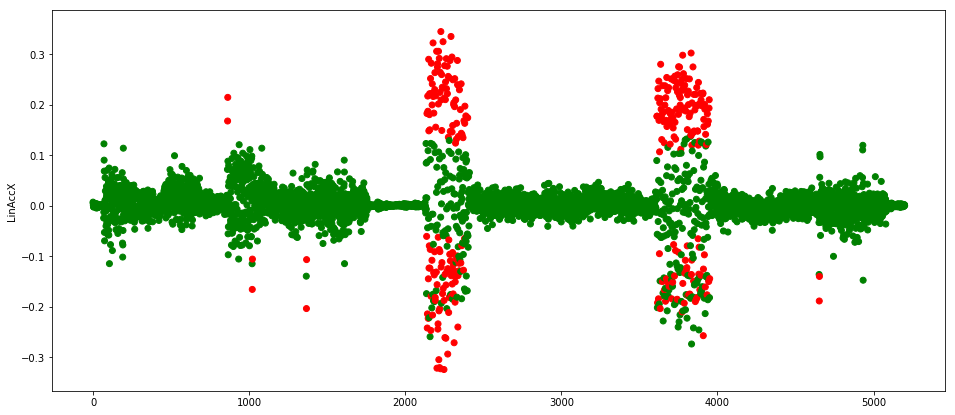

In [33]:
# Result visualization
anomaly = list(map(lambda v: "red" if v else "green", anomaly))
plt.scatter(list(range(len(validate_data_raw[" LinAccX (g)"]))), validate_data_raw[" LinAccX (g)"], c=anomaly)
plt.ylabel('LinAccX')
plt.show()